<a href="https://colab.research.google.com/github/SivalayaG/BioInf/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import halfnorm
from sklearn.svm import LinearSVC
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils._testing import ignore_warnings
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Obtain and clean our final train data

train_data = pd.read_csv('/content/drive/MyDrive/trainset2.csv')
train_data

,component1,component2,y
0,0.005477,-0.001006,1
1,0.204483,0.044904,1
2,-0.087482,0.021875,1
3,0.034319,-0.122092,1
4,0.039086,0.013469,1
...,...,...,...
587,0.172334,0.213057,1
588,-0.015920,-0.062548,1
589,0.263756,0.690210,1
590,0.218608,0.029319,1


In [ ]:
## We have 533 tumor genes data and 59 normal genes data

train_data.y.value_counts()

1    533
0     59
Name: y, dtype: int64

In [ ]:
## Create x and y separately from out train data

x = train_data.drop(['y'], axis = 1, inplace = False).to_numpy()
y = train_data[['y']].to_numpy()

x.shape, y.shape

((592, 2), (592, 1))

In [ ]:
## We split our data into train and test split by 80/20 ratio

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, stratify=y, test_size=0.20)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((473, 2), (473, 1), (119, 2), (119, 1))

In [ ]:
## We verify the stratified sampling in our test data 
## by checking number of tumors vs non-tumors

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0  12]
 [  1 107]]


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def val_acc_class_report_error_analysis(name, model, val_x, val_y, accuracy_only=False):
    pred_y  = model.predict(val_x)
    cm = confusion_matrix(val_y, pred_y)
    print('Model: {}'.format(name))
    
    ### Use the confusion matrix to compute (using NumPy) the accuracy (call the result 'val_acc')

    val_acc = (cm.trace()) / cm.sum()
    
    print('--- Validation accuracy: {: .2f}%\n'.format(val_acc*100))
    
    if accuracy_only:
        return
    
    classes = [str(d) for d in range(0, 10)]
    print('--- Classification Report: ')
    
    ### Print the classification report with 3 digits of precision
    
    print(classification_report(val_y, pred_y, digits=3))
          
    # fig = plt.figure(figsize=(10,8))
    # ax = plt.gca()
    # note: depending on your sklearn version, you may get a warning/error because `plot_confusion_matrix` is deprecated
    # if so, you should use ConfusionMatrixDisplay instead and fix the code so it plots the confusion matrix
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [ ]:
## Define our model and hyperparameters' range to tune for getting bext model

param_dist = dict(C=halfnorm.rvs(loc=0, scale=100.0, size=500), penalty=['l1', 'l2'], loss=['hinge', 'squared_hinge'])
model = LinearSVC(max_iter=5000, dual=True, random_state=42)

param_dist

{'C': array([1.11820641e+01, 9.76920599e+01, 1.61991739e+01, 3.07337842e+01,
        1.06427937e+02, 1.05637718e+02, 1.82199271e+02, 2.40206440e+02,
        3.06535435e+01, 1.87747516e+02, 1.52801947e+02, 7.91977675e+01,
        1.21566783e+02, 5.94498651e+01, 4.43520790e+01, 1.69094603e+01,
        3.95744941e+01, 4.44865283e+01, 6.82109806e+01, 2.26122088e+02,
        9.56153071e+01, 3.24281874e+01, 2.87436324e+01, 6.65613900e+00,
        8.21942674e+01, 3.54044951e+01, 2.87461234e+01, 3.06639719e+01,
        8.65179998e+01, 1.10817203e+02, 3.42535474e+01, 5.06349442e+01,
        8.80367578e+01, 3.25312859e+01, 1.33699096e+02, 3.45235113e+01,
        1.46809959e+01, 6.92334783e+01, 1.63098089e+02, 1.78817005e+02,
        2.34001691e+02, 2.18615373e+01, 1.89742062e+01, 4.61058119e+01,
        1.16477330e+02, 1.24115854e+02, 6.90372487e+01, 2.79277460e-02,
        1.21407599e+02, 1.05961545e+02, 2.49182983e+02, 3.73776653e+01,
        8.02898925e+01, 3.13459190e+01, 1.51737151e+02, 9.3

In [ ]:
## Train our model using RandomizedSearchCV with 10 kfold for cross validation


@ignore_warnings()
def do_randomized_search(model, param_dist):
    # RandomizedSearchCV class of scikit-learn to do a randomized search (use 'model')
    # We compute accuracy as scoring function and return the result of fit() on the training data 
    
    rs_cv = RandomizedSearchCV(model, param_distributions=param_dist, scoring='accuracy', cv = 10, random_state=42)
    return rs_cv.fit(train_x, train_y)

# Print best hyperparameters
rs_res = do_randomized_search(model, param_dist)
rs_res.best_params_

{'penalty': 'l2', 'loss': 'squared_hinge', 'C': 86.38303524381578}

Model: Support Vector Machine
--- Validation accuracy:  94.96%

--- Classification Report: 
              precision    recall  f1-score   support

           0      0.750     0.750     0.750        12
           1      0.972     0.972     0.972       107

    accuracy                          0.950       119
   macro avg      0.861     0.861     0.861       119
weighted avg      0.950     0.950     0.950       119



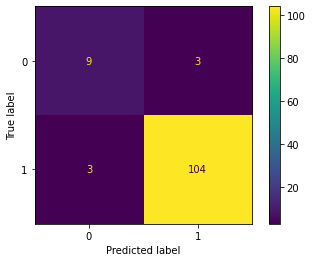

In [ ]:
## Print accuracy and classification report to analyze results

best_model = rs_res.best_estimator_
val_acc_class_report_error_analysis("Support Vector Machine", best_model, test_x, test_y)

In [ ]:
## SVM model is trained and results are visualized

In [ ]:
rs_res.best_score_

0.9407801418439717

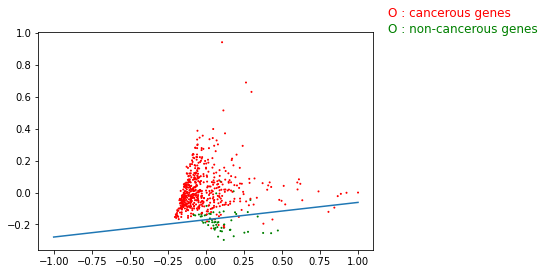

In [ ]:
color = ['green' if c == 0 else 'red' for c in y]
plt.scatter(train_data.iloc[:,0], train_data.iloc[:,1], c=color, marker="o", s=1)

# Create the hyperplane
w = best_model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-1,1)
yy = a * xx - (best_model.intercept_[0]) / w[1]

plt.text(1.2,1.1,'O : cancerous genes', fontsize = 12, color='r')
plt.text(1.2,1,'O : non-cancerous genes', fontsize = 12, color='g')


# Plot the hyperplane
plt.plot(xx, yy)
plt.show()